# AR(2)

In [3]:
import numpy as np
import pymc as pm
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
import arviz as az
import matplotlib.pyplot as plt

In [7]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate synthetic ARMA(1, 1) data
n = 1000
ar_coefs = [1, -.6, -.2]
ma_coefs = [1]

y = arma_generate_sample(ar_coefs, ma_coefs, nsample=n)

Text(0.5, 1.0, 'Generated AR(2) data')

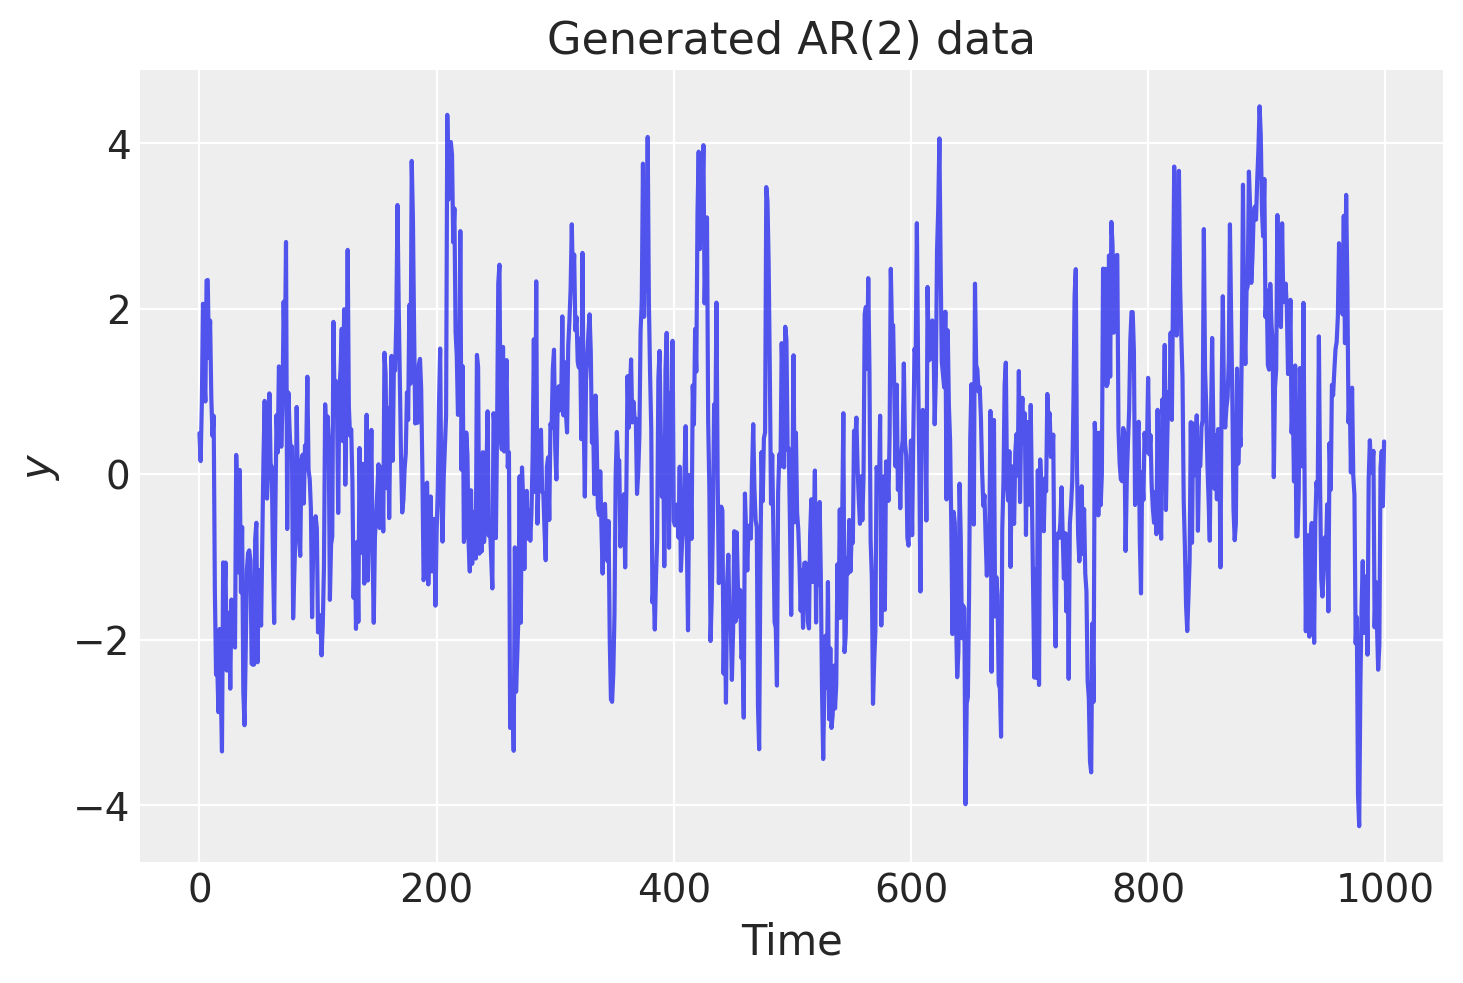

In [29]:
%config InlineBackend.figure_format = 'retina'

az.style.use("arviz-darkgrid")

plt.plot(y, alpha=0.8)
plt.xlabel("Time")
plt.ylabel(r"$y$")
plt.title('Generated AR(2) data')

/Users/wang/Library/CloudStorage/GoogleDrive-thetheoryofeverythingcn@gmail.com/My Drive/23 Spring/TimeSeries/Project/Bayesian-inference/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


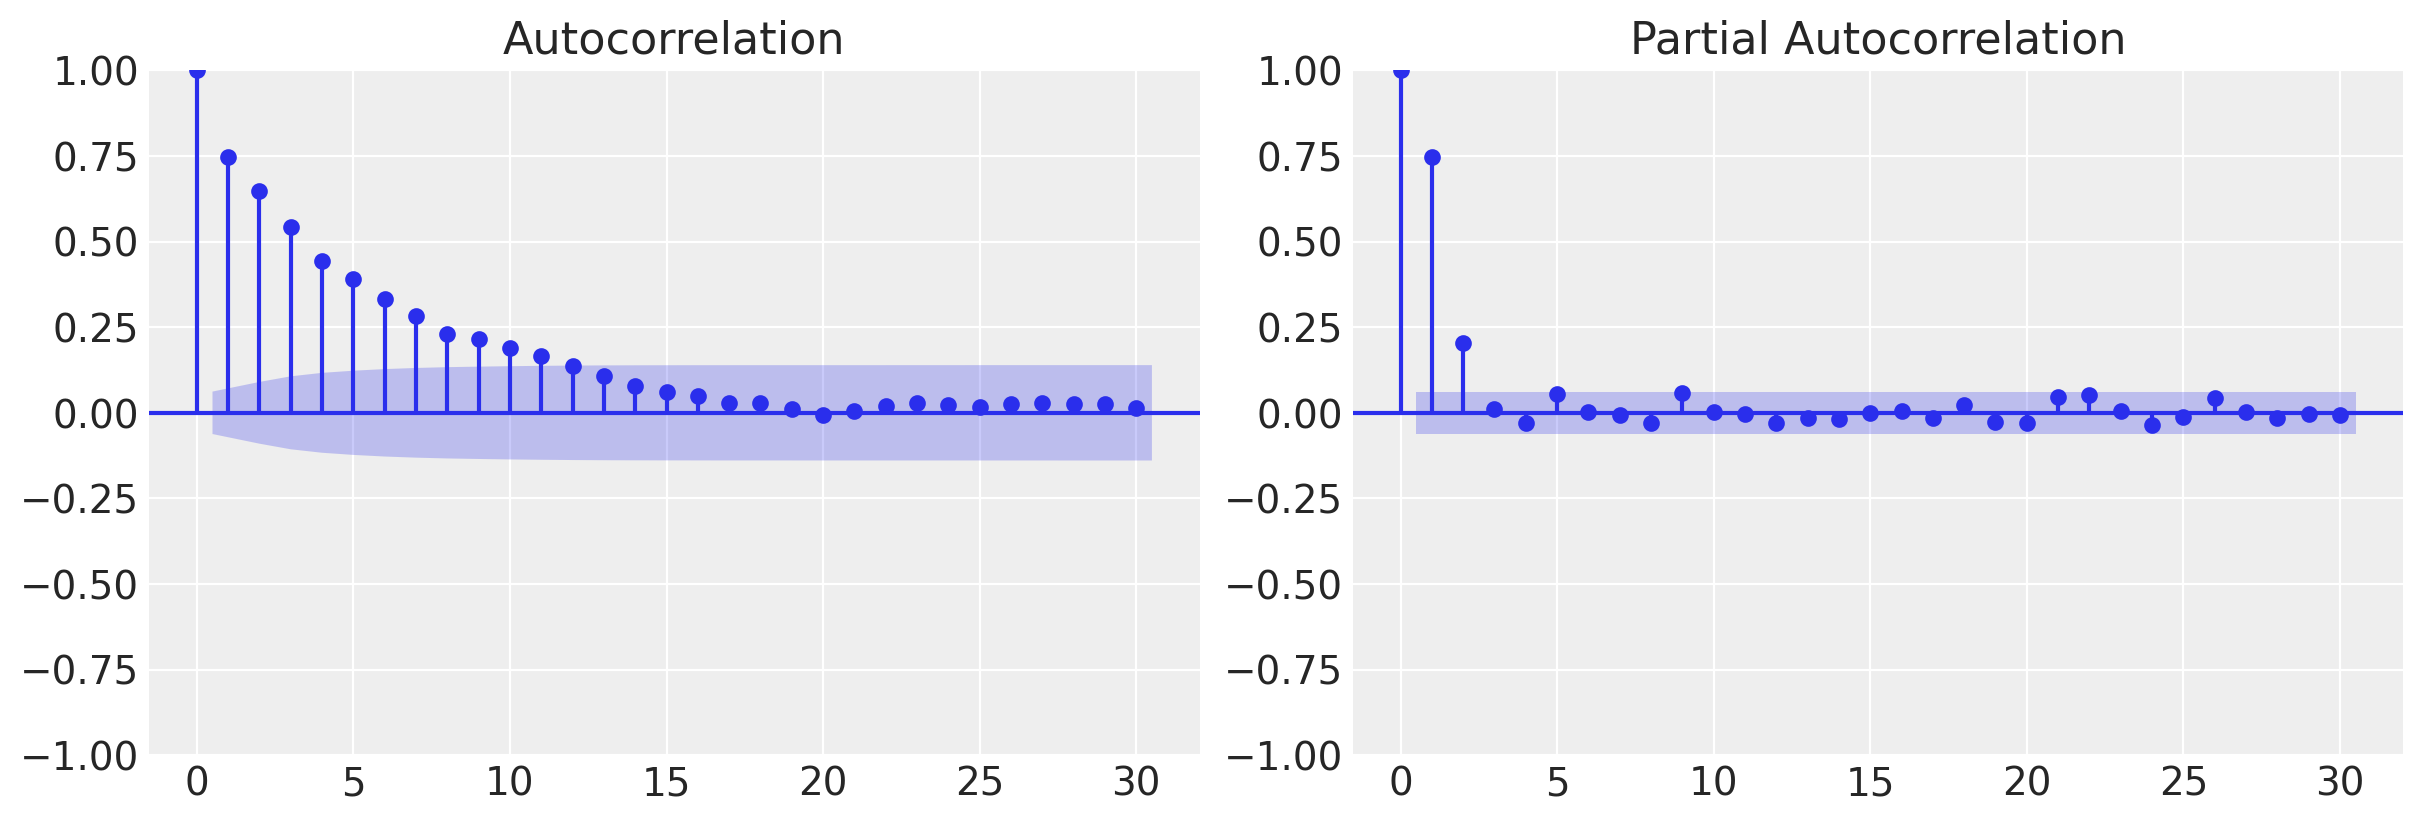

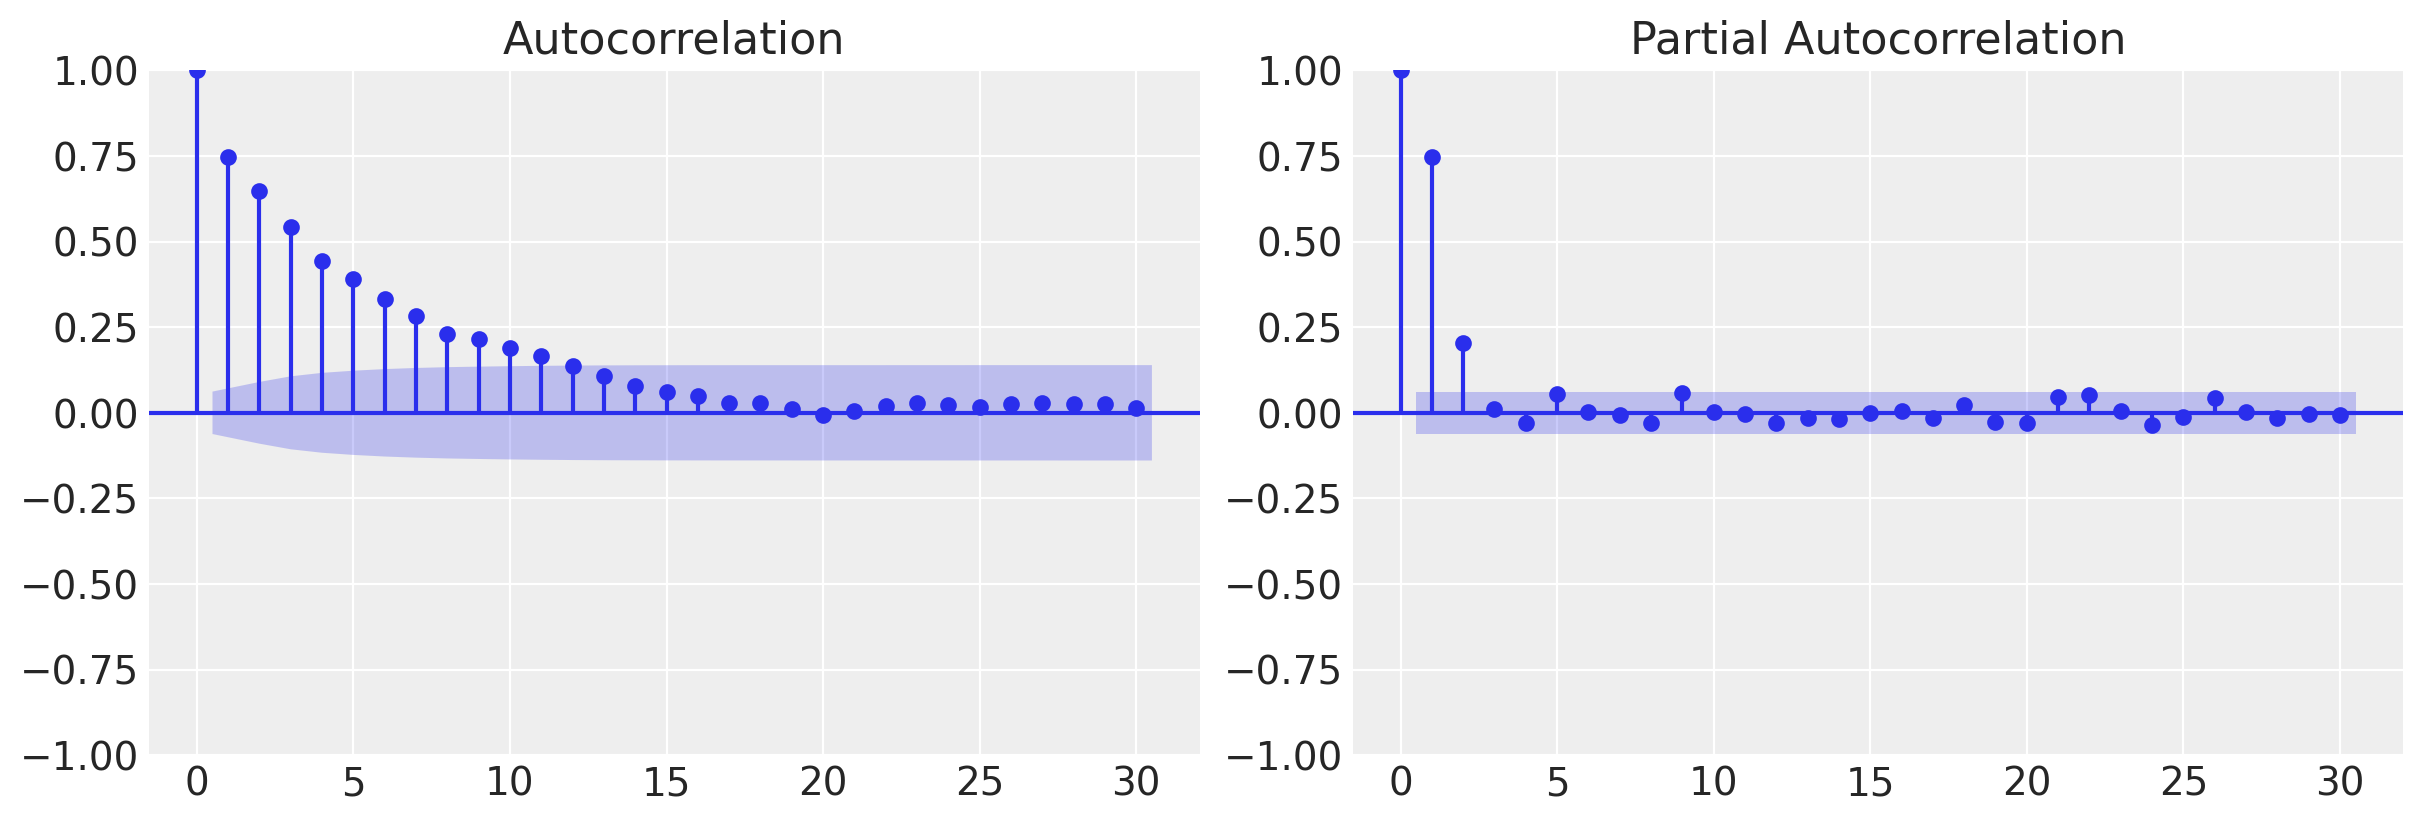

In [15]:
# plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y, ax=ax[0])
plot_pacf(y, ax=ax[1])

## MLE

In [60]:
mle = sm.tsa.ARIMA(y, order=(2, 0, 0), trend='n')
res = mle.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1415.201
Date:                Sun, 23 Apr 2023   AIC                           2836.401
Time:                        20:21:51   BIC                           2851.125
Sample:                             0   HQIC                          2841.997
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3129      0.027     11.579      0.000       0.260       0.366
ar.L2          0.5061      0.028     18.104      0.000       0.451       0.561
sigma2         0.9914      0.043     22.898      0.000       0.907       1.076
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 2.14
Prob(Q):                              0.44   Prob(JB):                         0.34
Heteroskedasticity (H):               1.01   Skew:                             0.10
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Bayesian inference 

### NUTs sampling

In [73]:
with pm.Model() as ar2:
    phi = pm.Normal("phi", mu=0.0, sigma=1.0, shape=2)
    sigma2 = pm.InverseGamma("sigma2", alpha=2, beta=4)

    likelihood = pm.AR(
        "y", rho=phi, tau=1/sigma2, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    trace = pm.sample(2000, tune=2000, step=pm.NUTS()) # nuts is the best

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, sigma2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma2'}>,
        <Axes: title={'center': 'sigma2'}>]], dtype=object)

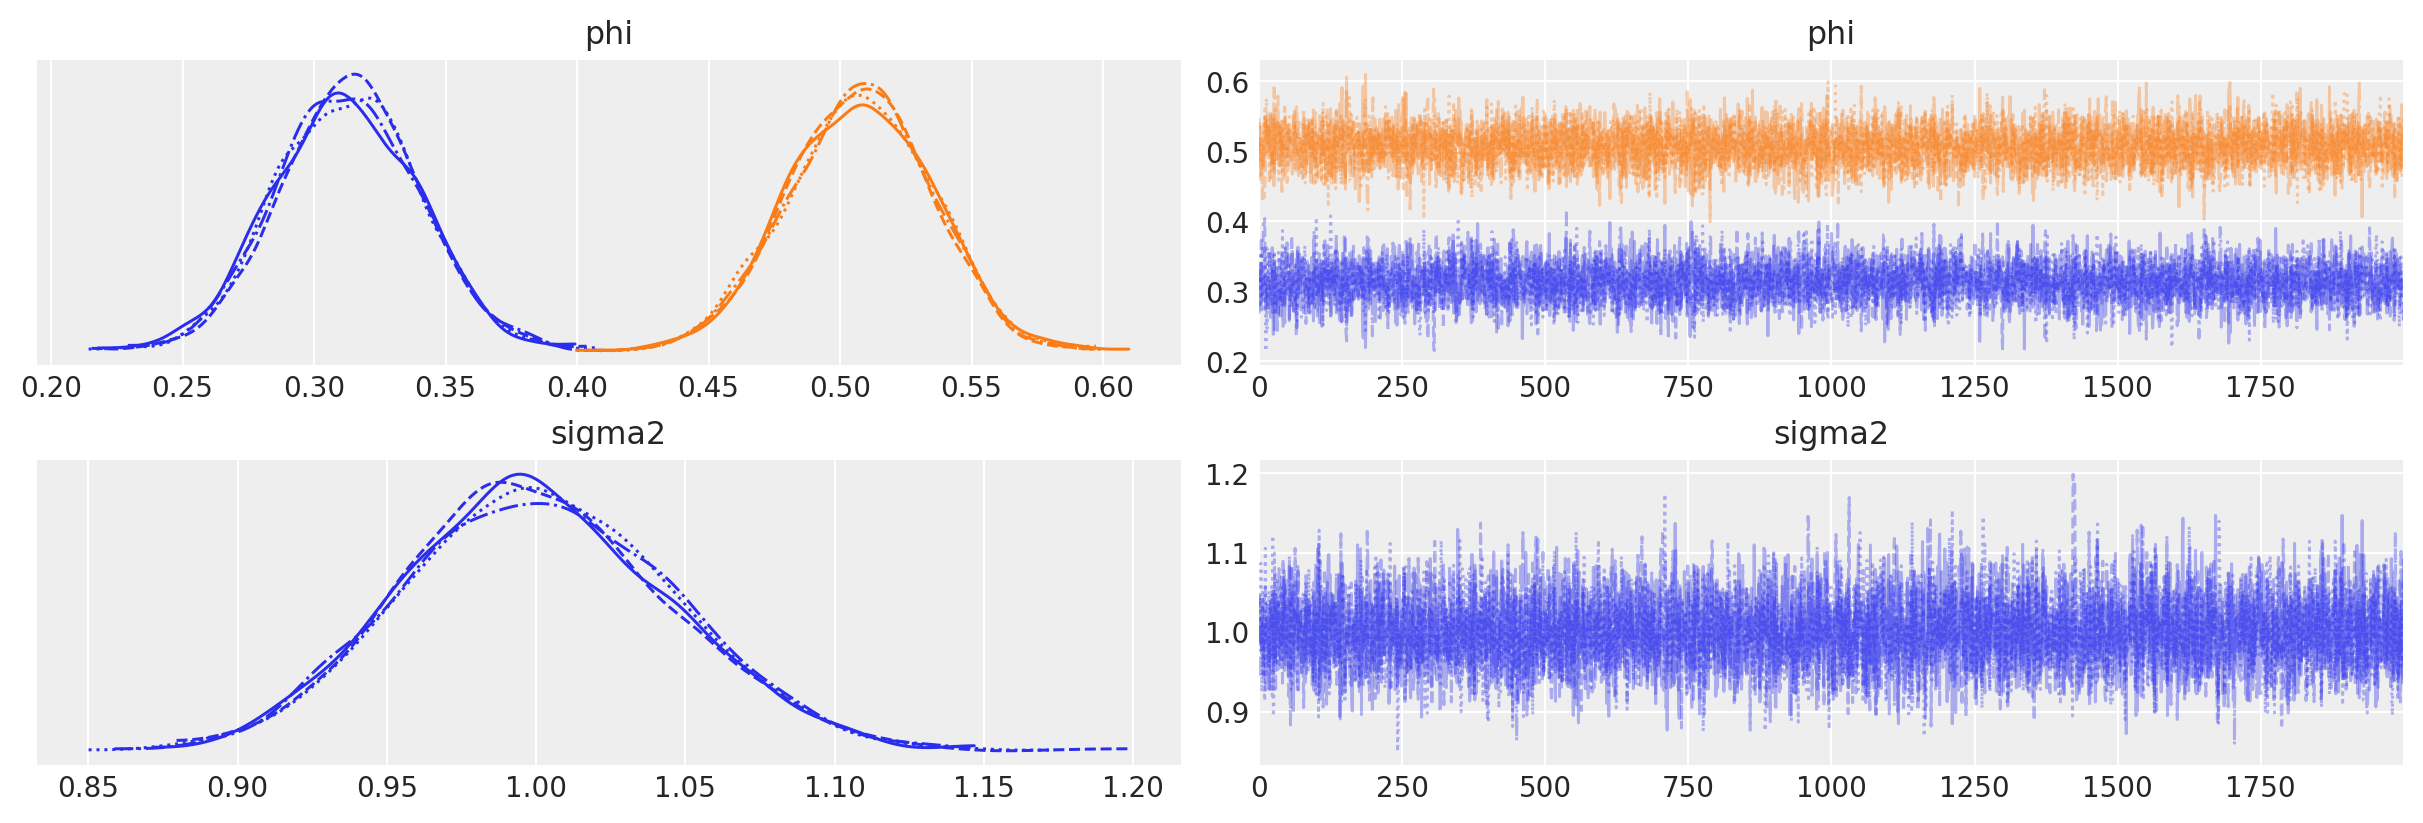

In [76]:
pm.plot_trace(trace, var_names=["phi", "sigma2"])

In [32]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi[0],0.594,0.031,0.536,0.652,0.000,0.0,4375.0,4565.0,1.0
phi[1],0.205,0.031,0.147,0.264,0.000,0.0,4086.0,5268.0,1.0
sigma2,0.967,0.043,0.888,1.052,0.001,0.0,6200.0,5425.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

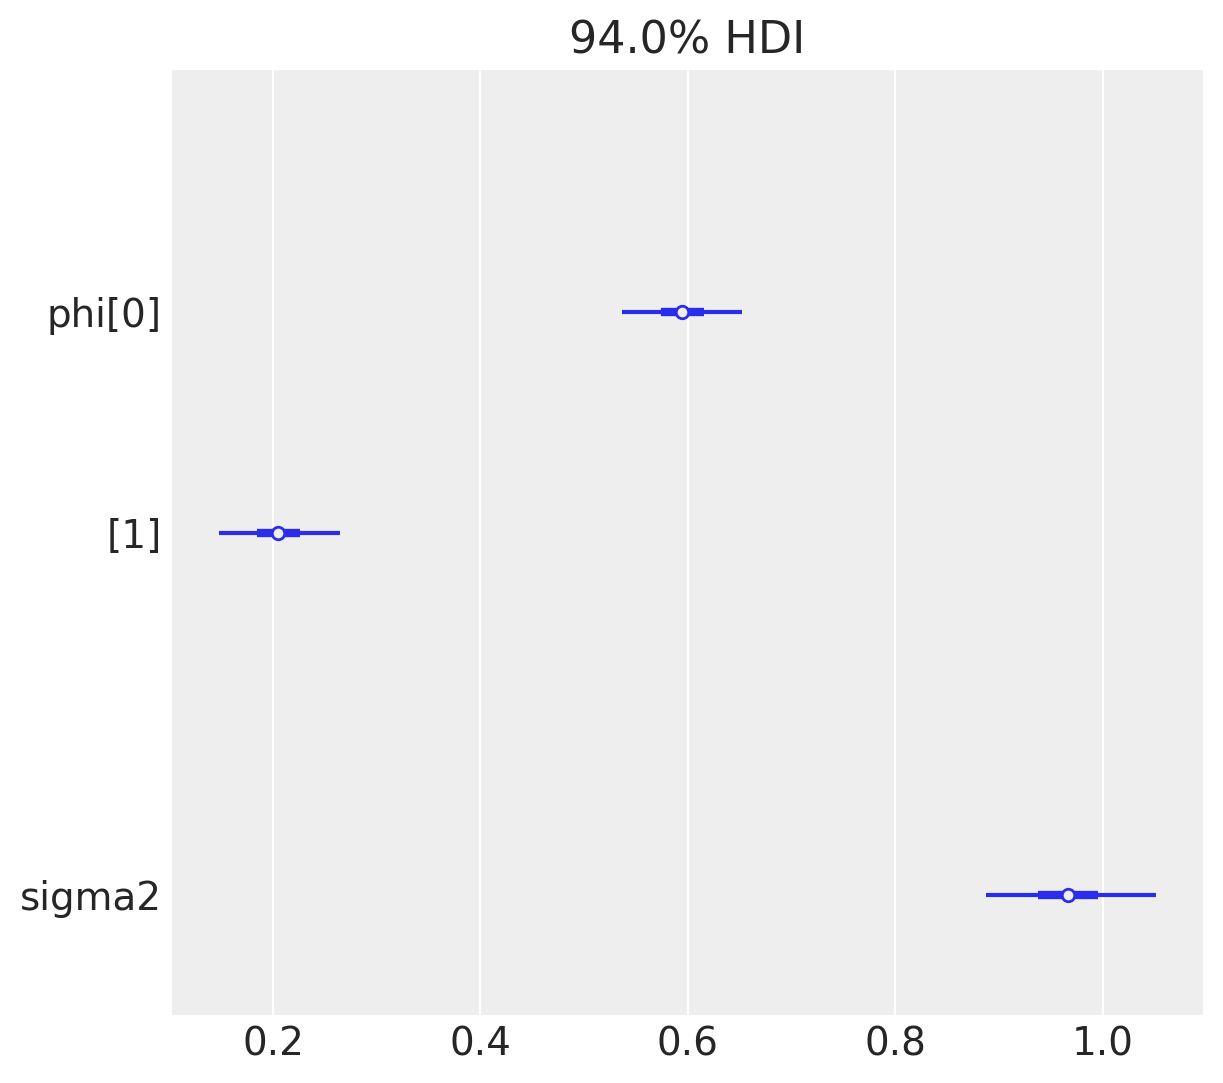

In [36]:
az.plot_forest(trace, combined=True)

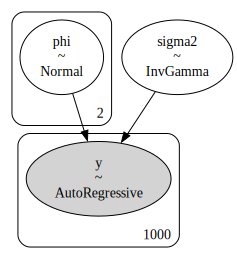

In [27]:
pm.model_to_graphviz(ar2)

### HMC sampling

In [49]:
with pm.Model() as ar2:
    phi = pm.Normal("phi", mu=0.0, sigma=1.0, shape=2)
    sigma2 = pm.InverseGamma("sigma2", alpha=2, beta=4)

    likelihood = pm.AR(
        "y", rho=phi, tau=1/sigma2, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    trace = pm.sample(2000, tune=2000, step=pm.HamiltonianMC()) 

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [phi, sigma2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma2'}>,
        <Axes: title={'center': 'sigma2'}>]], dtype=object)

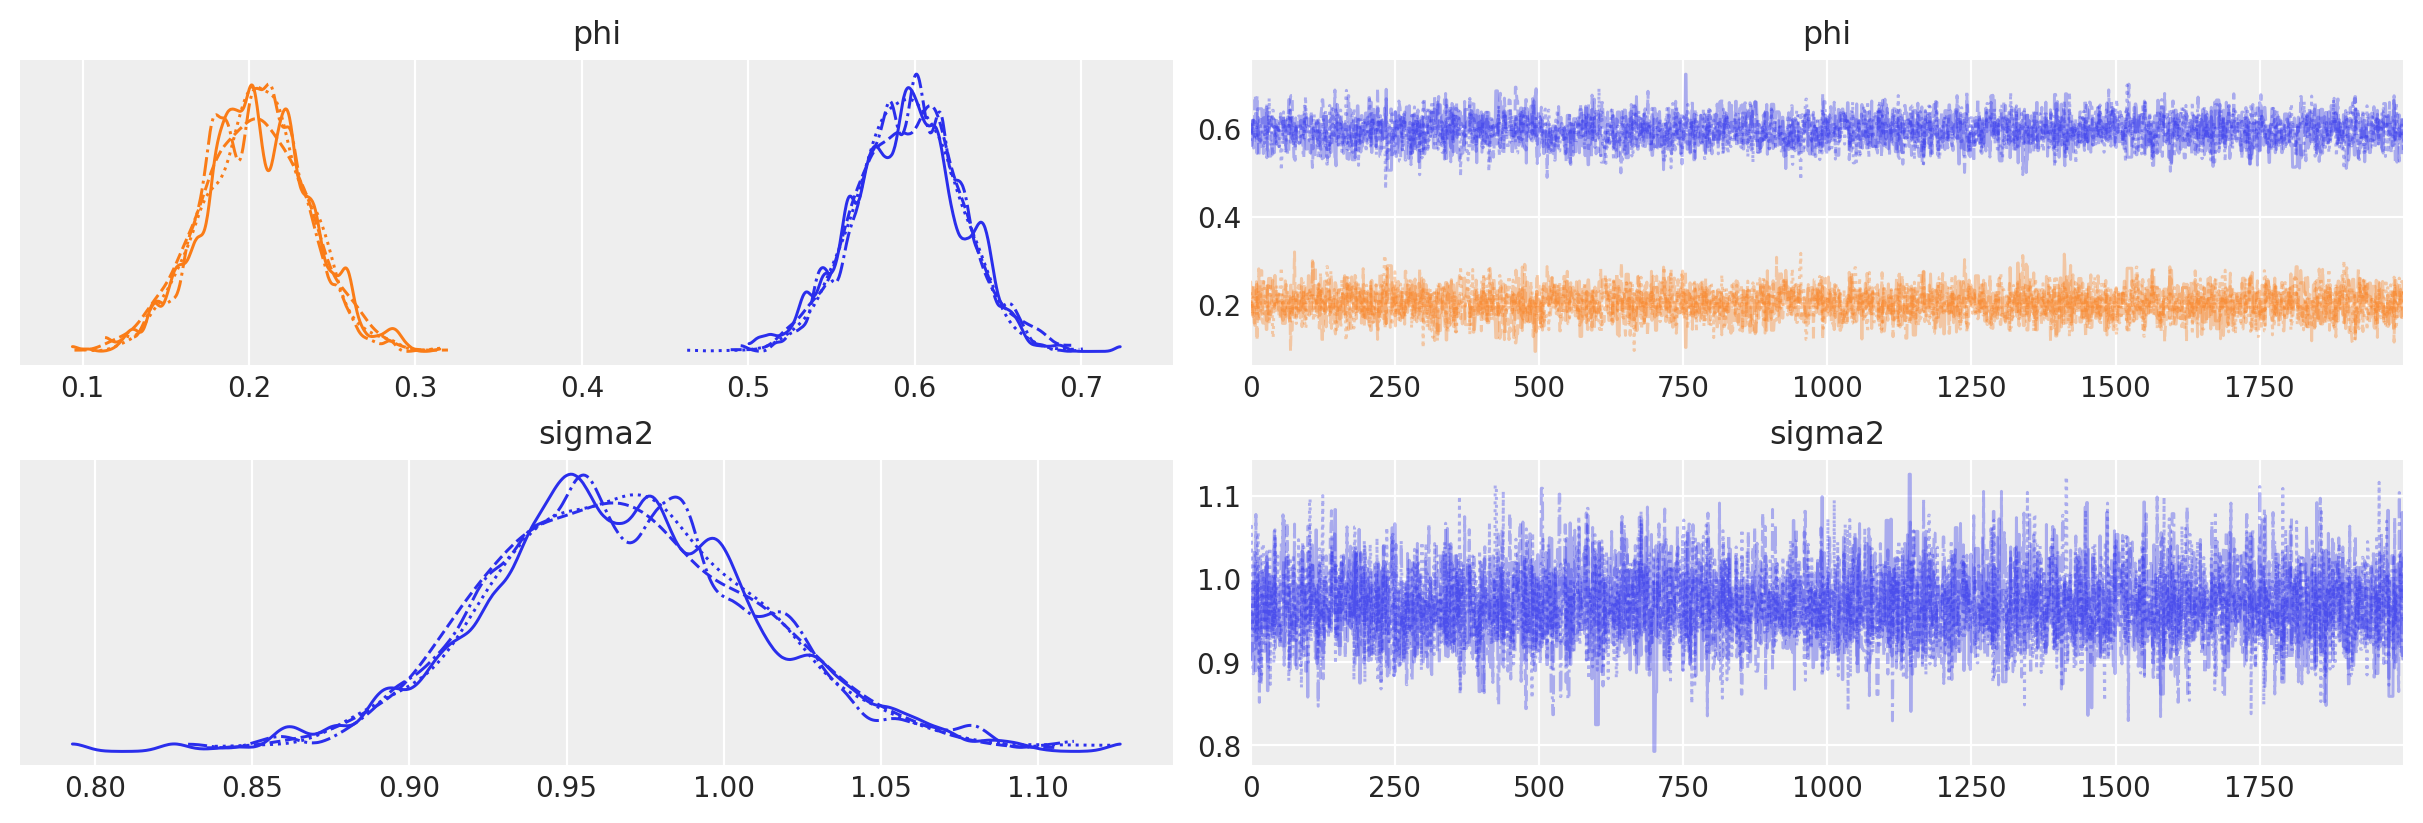

In [50]:
az.plot_trace(trace)

In [51]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi[0],0.596,0.031,0.532,0.650,0.001,0.0,2448.0,3066.0,1.0
phi[1],0.203,0.031,0.140,0.258,0.001,0.0,2420.0,2566.0,1.0
sigma2,0.968,0.044,0.886,1.051,0.001,0.0,4609.0,3509.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

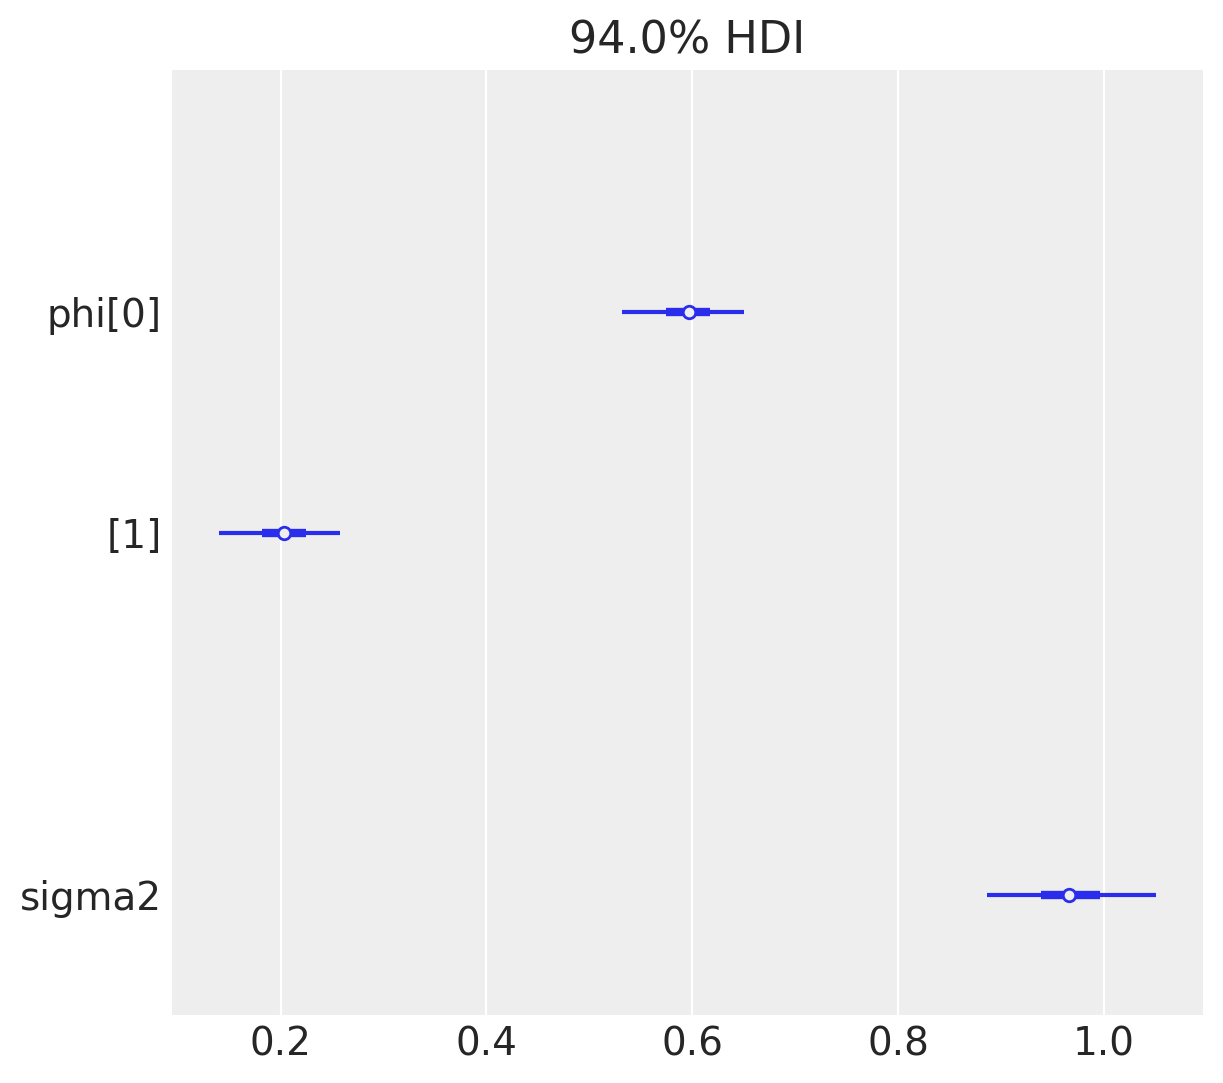

In [52]:
az.plot_forest(trace, combined=True)

### Metropolis sampling

In [44]:
with pm.Model() as ar2:
    phi = pm.Normal("phi", mu=0.0, sigma=1.0, shape=2)
    sigma2 = pm.InverseGamma("sigma2", alpha=2, beta=4)

    likelihood = pm.AR(
        "y", rho=phi, tau=1/sigma2, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    trace = pm.sample(2000, tune=2000, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [phi]
CompoundStep
>Metropolis: [phi]
>Metropolis: [sigma2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma2'}>,
        <Axes: title={'center': 'sigma2'}>]], dtype=object)

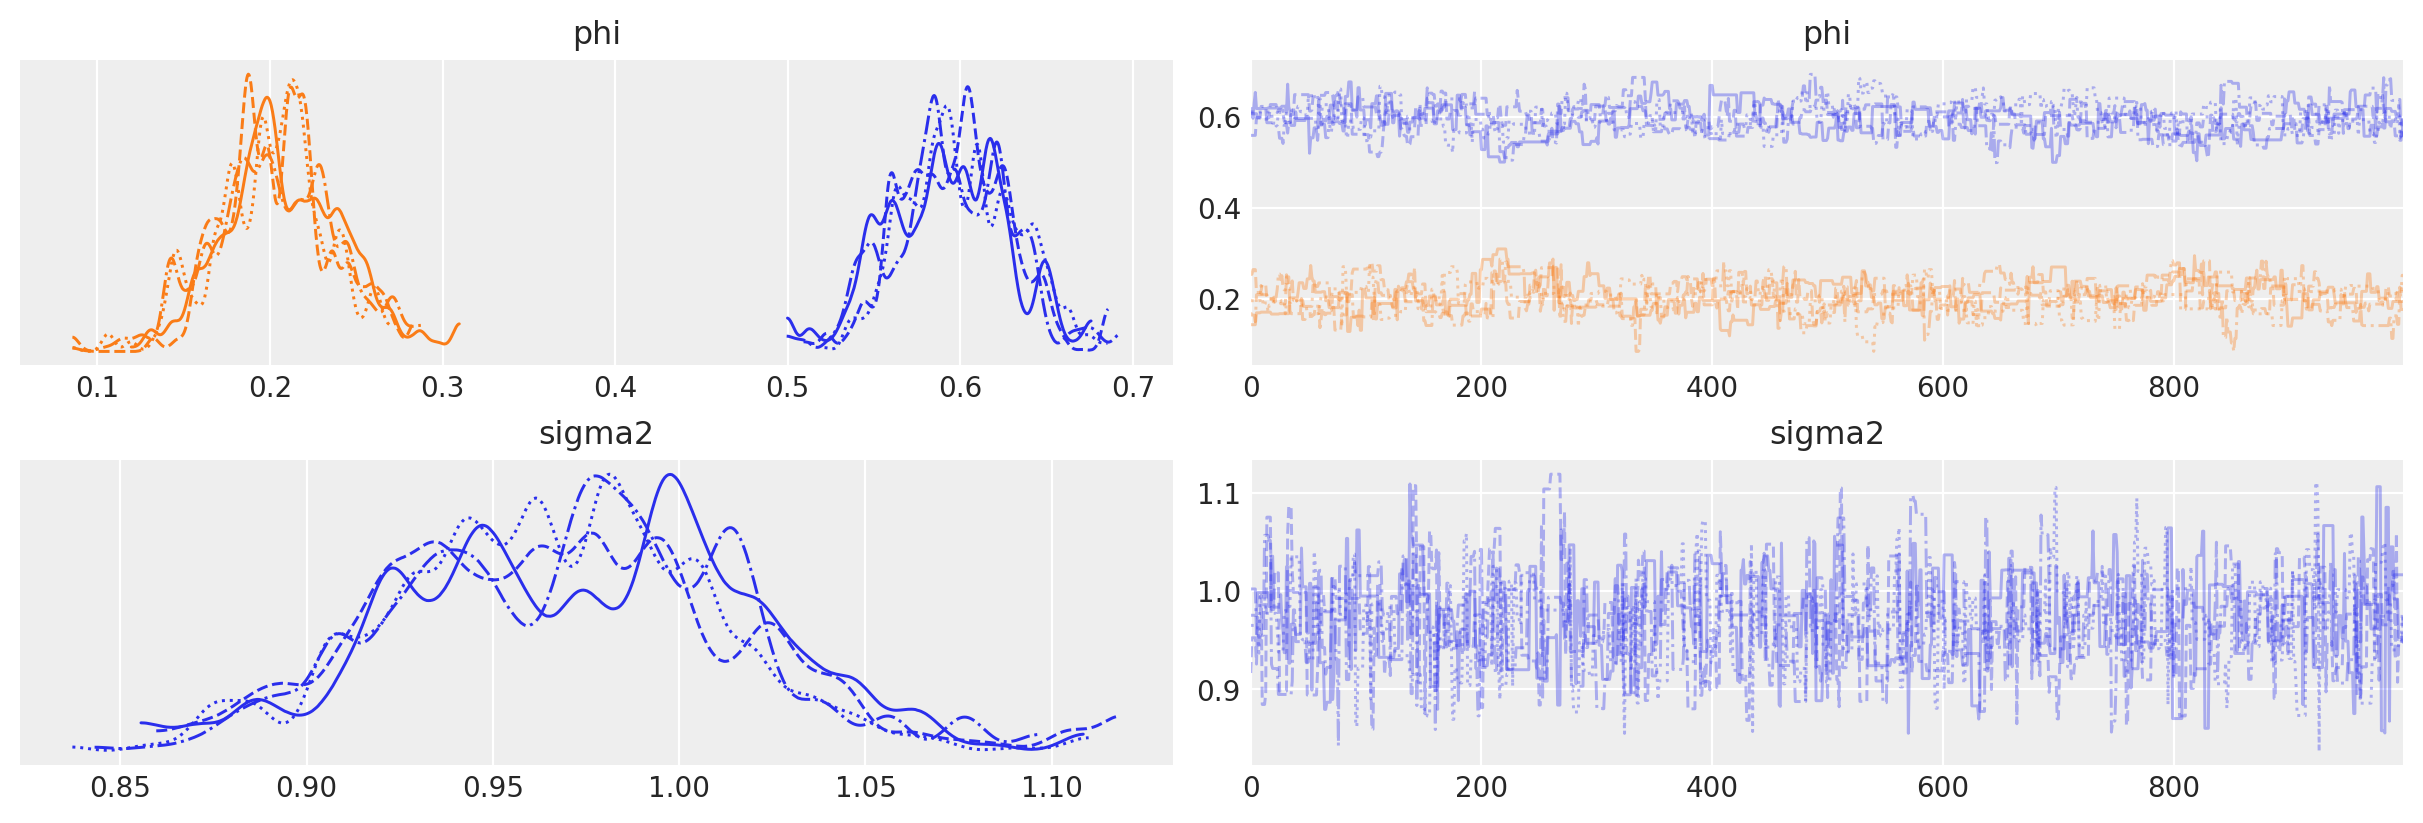

In [29]:
az.plot_trace(trace)

In [47]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi[0],0.595,0.031,0.537,0.654,0.002,0.001,364.0,497.0,1.02
phi[1],0.204,0.031,0.147,0.261,0.002,0.001,389.0,493.0,1.02
sigma2,0.967,0.043,0.880,1.043,0.001,0.001,1416.0,1479.0,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

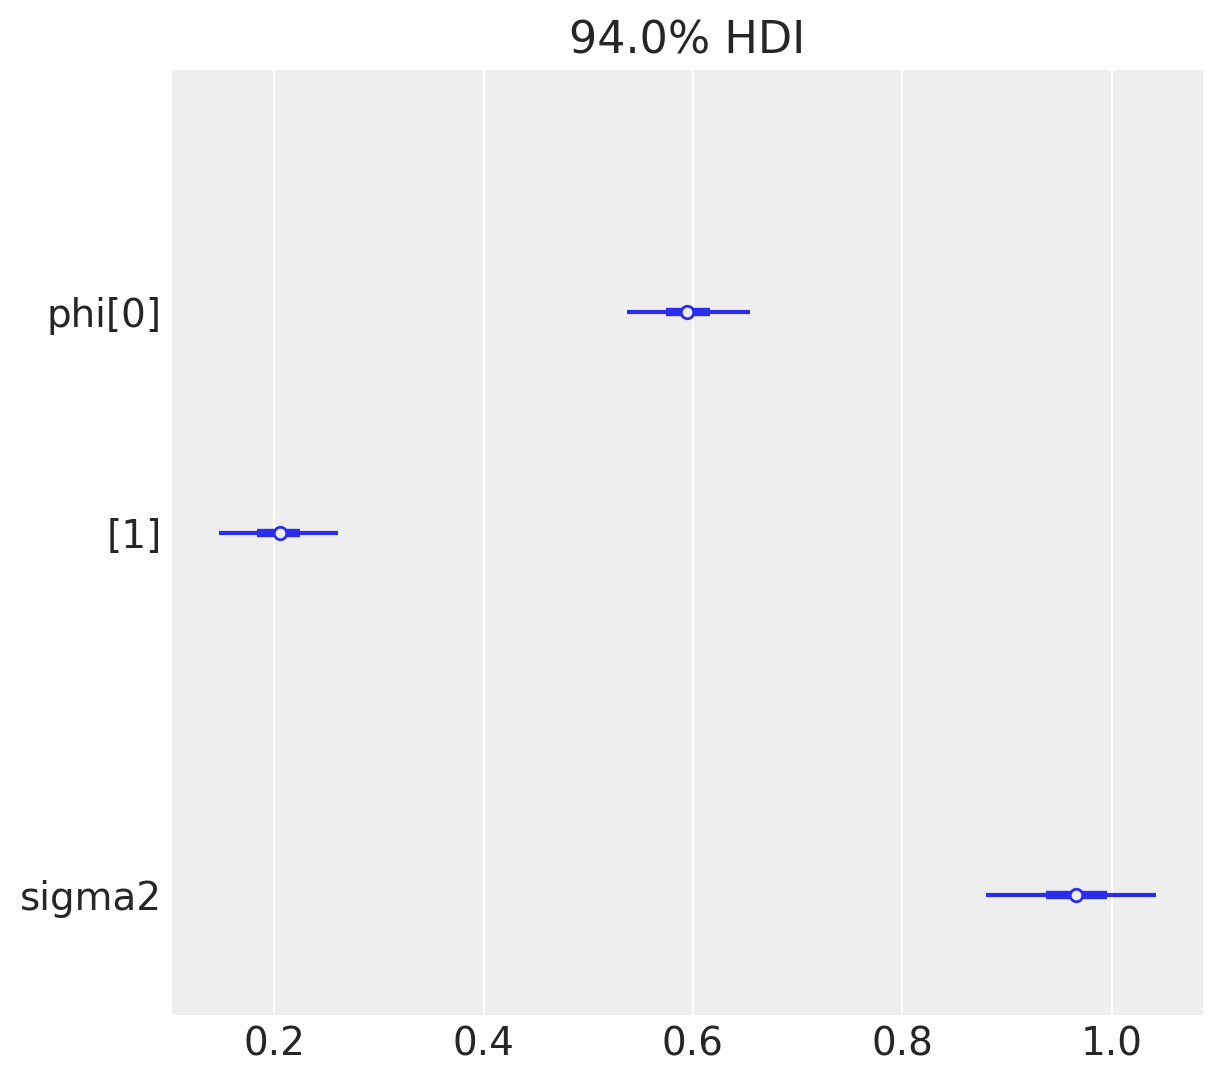

In [48]:
az.plot_forest(trace, combined=True)

## Comparison between Sampling methods 
1. In terms of time, the gradient free Metropolis is slightly more efficient (16s) than the two gradient based methods NUTs and HMC (18s each). 
2. In terms of effective sample size (`ESS`), NUTs and HMC are more efficient than Metropolis. This is because the two gradient based methods use leapfrog integrator to explore the parameter space more efficiently than Metropolis.
3. In terms of Rhat, NUTs and HMC have better convergence than Metropolis. This is also because they explored larger parameter space than Metropolis.

Overall, NUTs is the best method because 
1. Adaptive leapfrog steps: In HMC, the number of leapfrog steps is a crucial hyperparameter that needs to be tuned manually. Choosing an inappropriate number of leapfrog steps can lead to poor exploration of the target distribution and slow convergence. NUTS addresses this issue by adaptively determining the number of leapfrog steps at each iteration, eliminating the need to manually set this hyperparameter and improving sampling efficiency.

2. Efficient exploration of complex distributions: NUTS can more efficiently explore complex, high-dimensional, and correlated target distributions compared to Metropolis-Hastings algorithms. Metropolis-Hastings methods often suffer from slow exploration and high autocorrelation between samples, particularly in high-dimensional spaces. HMC and NUTS use auxiliary momentum variables to generate proposals that can efficiently explore the target distribution, reducing autocorrelation and improving convergence.

3. Reduced risk of getting stuck: NUTS stops the growth of the trajectory when it detects a U-turn, which indicates that the trajectory is doubling back on itself and is less likely to explore new regions of the parameter space efficiently. This feature reduces the risk of the sampler getting stuck in a region of the parameter space, leading to better exploration and faster convergence.

4. Automatic tuning: In addition to adaptively determining the number of leapfrog steps, NUTS also includes automatic tuning methods for other hyperparameters, such as the step size, further simplifying the tuning process and making it more user-friendly than HMC and Metropolis-Hastings algorithms.

However for models that do not support gradient, Metropolis is the only choice.

# ARMA(2, 2)

In [4]:
np.random.seed(42)
n = 1000
ar_coefs = np.array([.6, .2])
ma_coefs = np.array([-.3, .3])

y = arma_generate_sample(np.r_[1, -ar_coefs], np.r_[1, ma_coefs], nsample=n)

Text(0.5, 1.0, 'Generated ARMA(2, 2) data')

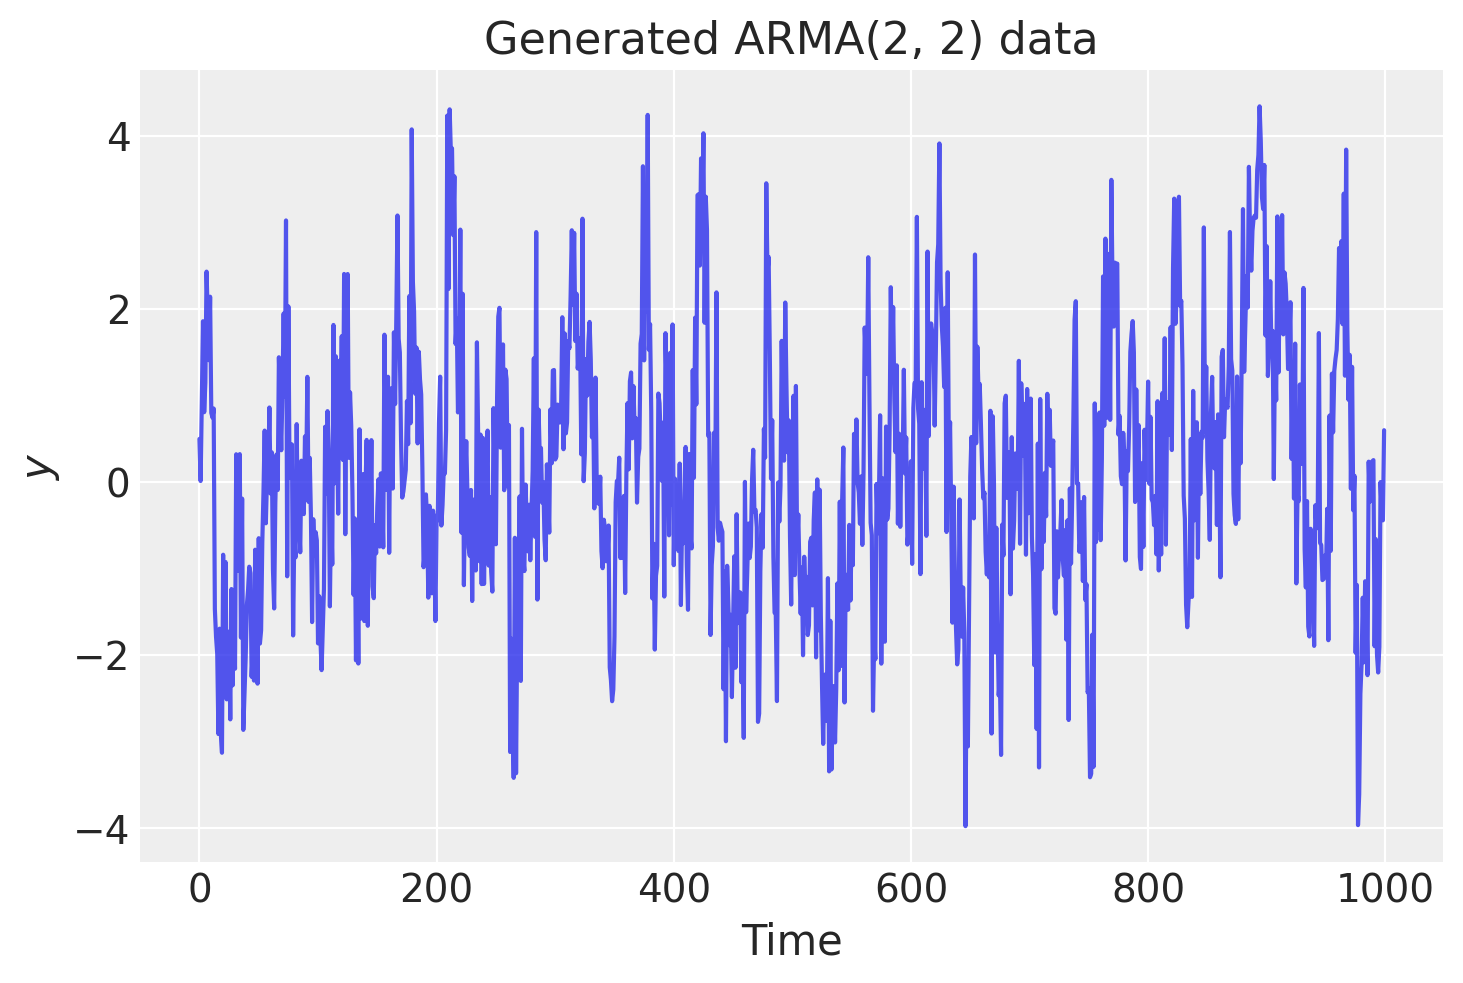

In [5]:
plt.plot(y, alpha=0.8)
plt.xlabel("Time")
plt.ylabel(r"$y$")
plt.title('Generated ARMA(2, 2) data')

## MLE

In [6]:
mle = sm.tsa.ARIMA(y, order=(2, 0, 2), trend='n')
res = mle.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1398.140
Date:                Fri, 28 Apr 2023   AIC                           2806.280
Time:                        13:15:16   BIC                           2830.819
Sample:                             0   HQIC                          2815.606
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5973      0.078      7.649      0.000       0.444       0.750
ar.L2          0.1943      0.075      2.598      0.009       0.048       0.341
ma.L1         -0.3006      0.077     -3.904      0.000      -0.451      -0.150
ma.L2          0.3172      0.053      6.024      0.000       0.214       0.420
sigma2         0.9581      0.042     22.553      0.000       0.875       1.041
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.90   Prob(JB):                         0.30
Heteroskedasticity (H):               1.02   Skew:                             0.12
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# estimated parameters
res.params

array([ 0.59726145,  0.19431813, -0.3005661 ,  0.31716257,  0.95805095])

In [8]:
# log-likelihood of the estimated parameters
mle.loglike(res.params)

-1398.1399939629173

In [9]:
# score of the estimated parameters
mle.score(res.params)

array([-0.00288423, -0.00610762,  0.00677112,  0.00672745,  0.00611078])

In [10]:
# score of the true parameters
mle.score([0.6,  0.2, -0.3,  0.3,  1]) # plug in the true values

array([ -6.14383856,  -1.112296  ,  -0.86484396,  10.54440947,
       -20.86285958])

In [11]:
# hessian matrix at the estimated parameters
hessian = mle.hessian(res.params)
for i in range(hessian.shape[0]):
    print(hessian[i, i])

-2.3287528194235407
-2.328515093658834
-1.1709166962723603
-1.1009322909306156
-0.5447571827856107


In [12]:
# fisher information matrix is not implemented
# mod.information(res_mle.params) 

In [13]:
res.get_prediction().summary_frame(alpha=0.05)

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.000000,1.492705,-2.925648,2.925648
1,0.313489,1.157861,-1.955877,2.582856
2,0.258652,0.993141,-1.687869,2.205172
3,0.295087,0.993104,-1.651361,2.241535
4,1.044602,0.980970,-0.878064,2.967268
...,...,...,...,...
995,-1.612669,0.978801,-3.531083,0.305745
996,-1.794657,0.978801,-3.713071,0.123757
997,-1.002744,0.978801,-2.921158,0.915671
998,0.158774,0.978801,-1.759640,2.077188


## Bayesian inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0, 0] [1, 1]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, phi, theta]
Sampling 4 chains for 400 tune and 2_000 draw iterations (1_600 + 8_000 draws total) took 22 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
phi[0]   -0.006  0.280  -0.319    0.555      0.133    0.101       7.0   
phi[1]    0.175  0.119   0.041    0.433      0.055    0.041       7.0   
theta[0]  0.308  0.280  -0.264    0.606      0.133    0.101       7.0   
theta[1]  0.298  0.123   0.066    0.463      0.053    0.040       8.0   
sigma     0.994  0.022   0.952    1.036      0.000    0.000    6054.0   

          ess_tail  r_hat  
phi[0]        33.0   1.54  
phi[1]        29.0   1.52  
theta[0]      31.0   1.54  
theta[1]      39.0   1.47  
sigma       4973.0   1.00  


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

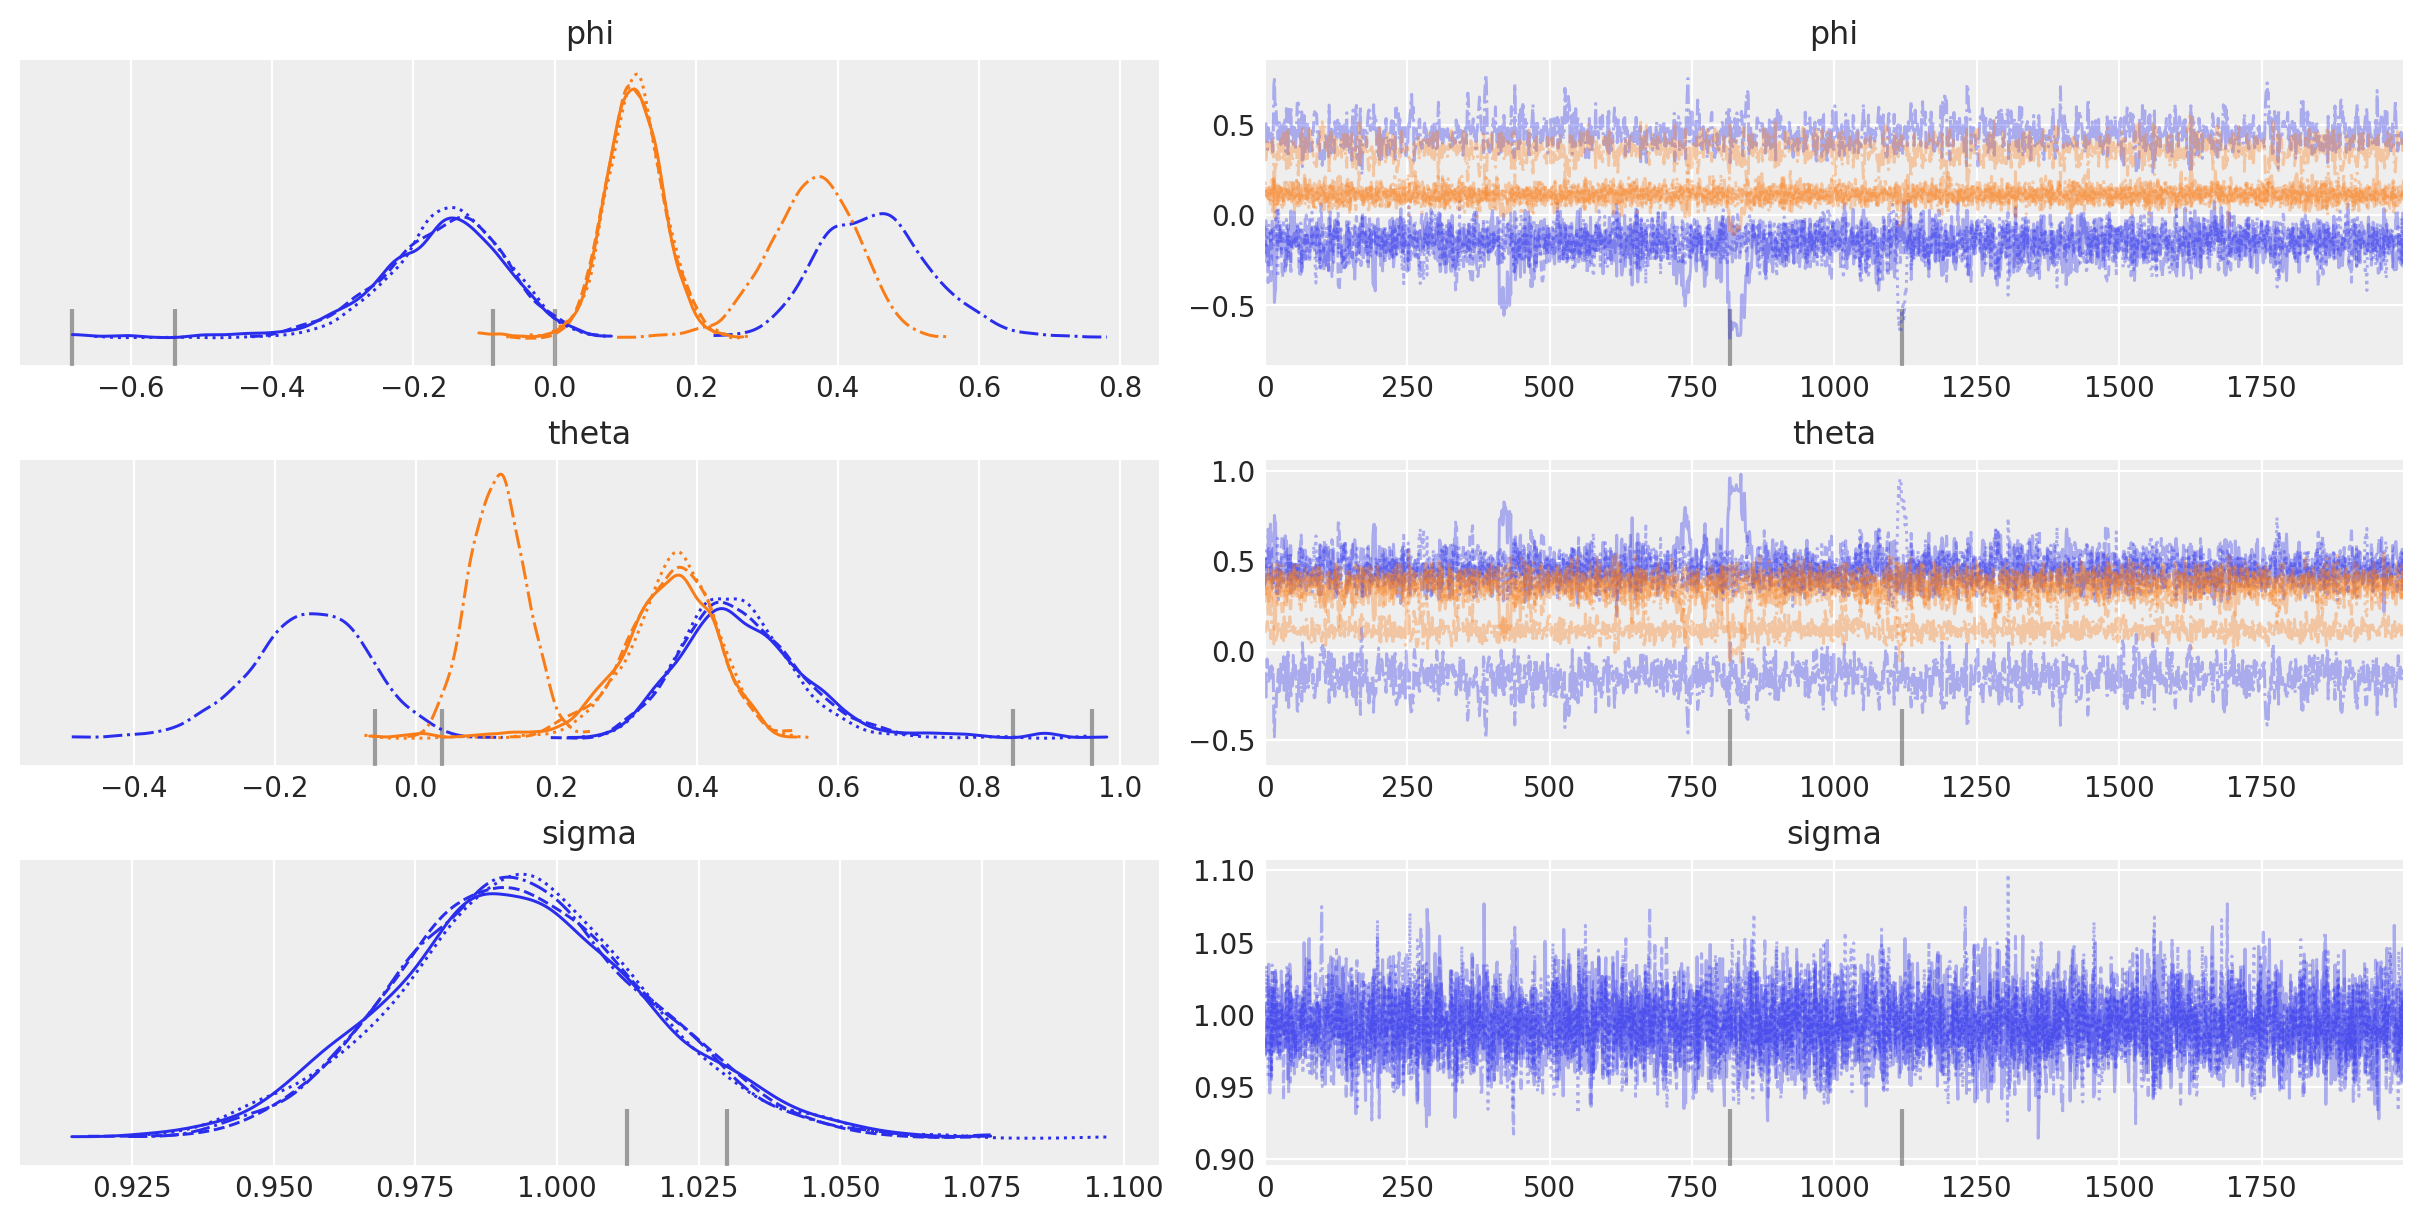

In [14]:
%load_ext autoreload
%autoreload 2
from arma_inference import run_MCMC_ARMApq
model = {'order': [2, 2], 'tab': {'params': [0,0,0,0], 'bse': [1,1,1,1]}}
trace = run_MCMC_ARMApq(y, 2000, model)
import arviz as az
az.style.use('arviz-darkgrid')
az.plot_trace(trace)